# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import joblib

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# sagemaker libraries
import boto3
import sagemaker

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='sagemaker-eu-west-1-848439228145'

Make a list withe files in the bucket and print the file names to be sure that we will be retrieving from the correct location and obtain

In [4]:
import re 

# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

def filter_csv(string):
    return re.search(r'.csv', string)


files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
filtered_list = list(filter(filter_csv, files))
    
    
# print csv objects in in S3 bucket  
print(filtered_list)

['Capstone/Udacity_AZDIAS_052018.csv', 'Capstone/Udacity_CUSTOMERS_052018.csv', 'Capstone/Udacity_MAILOUT_052018_TEST.csv', 'Capstone/Udacity_MAILOUT_052018_TRAIN.csv']


In [5]:
def load_dataframe_from_s3(s3_client, bucket, name):
    data_object = s3_client.get_object(Bucket=bucket, Key=name)
    data_body = data_object["Body"].read()
    data_stream = io.BytesIO(data_body)
    
    return pd.read_csv(data_stream, header=0, delimiter=",") 
    

In [6]:
customers_df = None
customers_df = load_dataframe_from_s3(s3_client, bucket_name, filtered_list[1])
customers_df.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
azdias_df = None
azdias_df = load_dataframe_from_s3(s3_client, bucket_name, filtered_list[0])
azdias_df.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [8]:
display(customers_df.describe())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95825.500000,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,0.000000,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47912.750000,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95825.500000,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143738.250000,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191651.000000,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [9]:
display(azdias_df.describe())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486465,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


Display nulls

In [10]:
rows = azdias_df.shape[0]
missing_values_azdias = azdias_df.isnull().sum().sort_values(ascending = False).divide(other = (rows/100))

display(missing_values_azdias)

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_KONSUMTYP                  28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_LOTTO                      28.849522
KBA05_SEG8                     14.959701
KBA05_SEG7                     14.959701
KBA05_KW2                      14.959701
KBA05_KW3                      14.959701
KBA05_MAXAH                    14.959701
KBA05_MAXBJ                    14.959701
KBA05_MAXHERST                 14.959701
KBA05_MAXSEG                   14.959701
KBA05_MAXVORB   

Discard the columns that have more than 28% of null values

In [11]:
#make a dict with the names of the columns and then drop this columns from dataframe
drop_columns = missing_values_azdias[missing_values_azdias > 28]

azdias_df.drop(columns = list(drop_columns.index), axis = 1, inplace = True)

azdias_df.shape

(891221, 351)

Discard the columns that have less than 0.5 variance

In [12]:
azdias_description = azdias_df.describe()


In [13]:
std_df = azdias_description.loc[['std']].values.reshape(346,)
std_serie = pd.Series(std_df, index =azdias_description.columns) 

drop_lowdispersion_cols = std_serie[std_serie < 0.5]

azdias_df.drop(columns = list(drop_lowdispersion_cols.index), axis = 1, inplace = True)

In [14]:
def memory_usage(df):
    return(round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))

print('Memory used:', memory_usage(azdias_df), 'Mb')


Memory used: 2486.31 Mb


In [15]:
print(list(azdias_df.columns.values))

['Unnamed: 0', 'LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_

In [16]:
azdias_df['CAMEO_INTL_2015'].replace('XX',np.nan, inplace = True)
azdias_df['CAMEO_DEUG_2015'].replace('X',np.nan, inplace = True)


In [17]:
#It is necessary to reduce the size of the dataframe in order to optimize the memory usage

def to_category(df, categorical_columns):
    for column in categorical_columns:
        df[column] = df[column].astype('category', inplace = True)
    
    return df

def to_int(df, categorical_columns):
    for column in categorical_columns:
        df[column] = df[column].astype('uint8', inplace = True)
    
    return df

categorical_columns = [
                        'ALTERSKATEGORIE_GROB','AGER_TYP','ALTER_HH',
                      'BALLRAUM','CAMEO_DEUG_2015','CAMEO_DEU_2015','D19_BANKEN_ANZ_24',
                      'CJT_GESAMTTYP','D19_BANKEN_ANZ_12','D19_BANKEN_DATUM',
                      'D19_BANKEN_OFFLINE_DATUM',
                      'D19_BANKEN_ONLINE_DATUM','D19_BANKEN_DIREKT','D19_BANKEN_GROSS',
                      'D19_BANKEN_LOKAL','D19_BANKEN_REST',
                      'D19_BEKLEIDUNG_GEH','D19_BEKLEIDUNG_REST','D19_BILDUNG',
                      'D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV','D19_DROGERIEARTIKEL',
                      'D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_GESAMT_ANZ_12',
                      'D19_GESAMT_ANZ_24','D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM',
                      'D19_HANDWERK','D19_HAUS_DEKO','D19_KINDERARTIKEL',
                      'D19_KONSUMTYP_MAX','D19_KOSMETIK','D19_LEBENSMITTEL','D19_NAHRUNGSERGAENZUNG',
                      'D19_RATGEBER','D19_REISEN','D19_SAMMELARTIKEL','D19_SCHUHE','D19_SONSTIGE',
                      'D19_TECHNIK','D19_TELKO_DATUM',
                      'D19_TELKO_MOBILE','D19_TELKO_OFFLINE_DATUM',
                       'D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_ANZ_12',
                      'D19_VERSAND_ANZ_24','D19_VERSAND_DATUM','D19_VERSAND_DATUM',
                      'D19_VERSAND_ONLINE_DATUM','D19_VERSAND_REST','D19_VERSICHERUNGEN',
                      'D19_VERSI_ANZ_24','D19_VOLLSORTIMENT','D19_WEIN_FEINKOST','EWDICHTE',
                      'FINANZTYP','FINANZ_ANLEGER','FINANZ_HAUSBAUER','FINANZ_MINIMALIST',
                      'FINANZ_SPARER','FINANZ_UNAUFFAELLIGER','FINANZ_VORSORGER',
                      'GEBAEUDETYP','GEBAEUDETYP_RASTER','GFK_URLAUBERTYP',
                      'STRUKTURTYP','HEALTH_TYP',
                      'HH_EINKOMMEN_SCORE','INNENSTADT','KBA05_ALTER1','KBA05_ALTER2',
                      'KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG','KBA05_ANTG1','KBA05_ANTG2',
                      'KBA05_ANTG3','KBA05_ANTG4','KBA05_AUTOQUOT','KBA05_BAUMAX','KBA05_CCM1',
                    'KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL','KBA05_FRAU','KBA05_GBZ',
                    'KBA05_HERST1','KBA05_HERST2','KBA05_HERST3','KBA05_HERST4','KBA05_HERST5',
                    'KBA05_HERSTTEMP','KBA05_KRSAQUOT','KBA05_KRSHERST1','KBA05_KRSHERST2',
                    'KBA05_KRSHERST3','KBA05_KRSKLEIN','KBA05_KRSOBER','KBA05_KRSVAN',
                    'KBA05_KRSZUL','KBA05_KW1','KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ',
                    'KBA05_MAXHERST','KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1','KBA05_MOD2',
                    'KBA05_MOD3','KBA05_MOD4','KBA05_MOD8','KBA05_MODTEMP','KBA05_MOTOR',
                    'KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG10','KBA05_SEG2','KBA05_SEG3',
                    'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_SEG7','KBA05_SEG8','KBA05_SEG9',
                    'KBA05_VORB0','KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1','KBA05_ZUL2',
                    'KBA05_ZUL3','KBA05_ZUL4','KBA13_ALTERHALTER_30','KBA13_ALTERHALTER_45',
                    'KBA13_ALTERHALTER_60','KBA13_ALTERHALTER_61','KBA13_AUDI','KBA13_AUTOQUOTE',
                    'KBA13_BJ_1999','KBA13_BJ_2000','KBA13_BJ_2004','KBA13_BJ_2006',
                    'KBA13_BJ_2008','KBA13_BJ_2009','KBA13_BMW','KBA13_CCM_1000','KBA13_CCM_1200',
                    'KBA13_CCM_1400','KBA13_CCM_0_1400','KBA13_CCM_1500','KBA13_CCM_1401_2500',
                    'KBA13_CCM_1600','KBA13_CCM_1800','KBA13_CCM_2000','KBA13_CCM_2500',
                    'KBA13_CCM_2501','KBA13_CCM_3000','KBA13_CCM_3001','KBA13_FAB_ASIEN',
                    'KBA13_FAB_SONSTIGE','KBA13_FIAT','KBA13_FORD','KBA13_HALTER_20',
                    'KBA13_HALTER_25','KBA13_HALTER_30','KBA13_HALTER_35','KBA13_HALTER_40',
                    'KBA13_HALTER_45','KBA13_HALTER_50','KBA13_HALTER_55','KBA13_HALTER_60',
                    'KBA13_HALTER_65','KBA13_HALTER_66','KBA13_HERST_ASIEN','KBA13_HERST_AUDI_VW',
                    'KBA13_HERST_BMW_BENZ','KBA13_HERST_EUROPA','KBA13_HERST_FORD_OPEL',
                    'KBA13_HERST_SONST','KBA13_KMH_110','KBA13_KMH_140','KBA13_KMH_180',
                    'KBA13_KMH_0_140','KBA13_KMH_140_210','KBA13_KMH_211','KBA13_KMH_250',
                    'KBA13_KMH_251','KBA13_KRSAQUOT','KBA13_KRSHERST_AUDI_VW',
                    'KBA13_KRSHERST_BMW_BENZ','KBA13_KRSHERST_FORD_OPEL',
                    'KBA13_KRSSEG_OBER','KBA13_KRSSEG_VAN','KBA13_KRSZUL_NEU','KBA13_KW_30',
                    'KBA13_KW_40','KBA13_KW_50','KBA13_KW_60','KBA13_KW_0_60','KBA13_KW_70',
                    'KBA13_KW_61_120','KBA13_KW_80','KBA13_KW_90','KBA13_KW_110','KBA13_KW_120',
                    'KBA13_KW_121','KBA13_MAZDA','KBA13_MERCEDES','KBA13_MOTOR','KBA13_NISSAN',
                    'KBA13_OPEL','KBA13_PEUGEOT','KBA13_RENAULT','KBA13_SEG_GELAENDEWAGEN',
                    'KBA13_SEG_GROSSRAUMVANS','KBA13_SEG_KLEINST','KBA13_SEG_KLEINWAGEN',
                    'KBA13_SEG_KOMPAKTKLASSE','KBA13_SEG_MINIVANS','KBA13_SEG_MINIWAGEN',
                    'KBA13_SEG_MITTELKLASSE','KBA13_SEG_OBEREMITTELKLASSE','KBA13_SEG_OBERKLASSE',
                    'KBA13_SEG_SONSTIGE','KBA13_SEG_SPORTWAGEN','KBA13_SEG_UTILITIES',
                    'KBA13_SEG_VAN','KBA13_SEG_WOHNMOBILE','KBA13_SITZE_4','KBA13_SITZE_5',
                    'KBA13_SITZE_6','KBA13_TOYOTA','KBA13_VORB_0','KBA13_VORB_1','KBA13_VORB_1_2',
                    'KBA13_VORB_2','KBA13_VORB_3','KBA13_VW','KKK','KONSUMNAEHE','LP_FAMILIE_FEIN',
                    'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN',
                    'LP_STATUS_GROB','MOBI_REGIO','NATIONALITAET_KZ','ONLINE_AFFINITAET','ORTSGR_KLS9',
                    'OST_WEST_KZ','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX',
                    'PLZ8_GBZ','PLZ8_HHZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','RELAT_AB',
                    'RETOURTYP_BK_S','SEMIO_DOM','SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT',
                    'SEMIO_KULT','SEMIO_LUST','SEMIO_MAT','SEMIO_PFLICHT','SEMIO_RAT','SEMIO_REL',
                    'SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','SHOPPER_TYP',
                    'VERS_TYP','WOHNDAUER_2008','WOHNLAGE','W_KEIT_KIND_HH','ZABEOTYP']

#GEBURTSJAHR year of birth, to int or to date
#GREEN_AVANTGARDE maybe can be a bool
azdias_df = to_category(azdias_df, categorical_columns)
#azdias_df = to_int(azdias_df, categorical_columns)

print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 650.54 Mb


Digging for more space it can be seen that there are columns that are not listed in the csv description

In [18]:
(azdias_df.memory_usage(deep=True) / 1024 ** 2).sort_values(ascending = False)

EINGEFUEGT_AM                 60.686382
CAMEO_INTL_2015               39.016406
ANZ_STATISTISCHE_HAUSHALTE     6.799477
KBA13_GBZ                      6.799477
CJT_KATALOGNUTZER              6.799477
RT_SCHNAEPPCHEN                6.799477
RT_KEIN_ANREIZ                 6.799477
AKT_DAT_KL                     6.799477
KBA13_HHZ                      6.799477
ANZ_HAUSHALTE_AKTIV            6.799477
ANZ_KINDER                     6.799477
ANZ_PERSONEN                   6.799477
ARBEIT                         6.799477
D19_VERSI_OFFLINE_DATUM        6.799477
D19_VERSAND_OFFLINE_DATUM      6.799477
CJT_TYP_6                      6.799477
CJT_TYP_5                      6.799477
CJT_TYP_4                      6.799477
MOBI_RASTER                    6.799477
MIN_GEBAEUDEJAHR               6.799477
CJT_TYP_3                      6.799477
CJT_TYP_2                      6.799477
CJT_TYP_1                      6.799477
KOMBIALTER                     6.799477
D19_VERSI_DATUM                6.799477


In [19]:
categorical_columns2 = ['CAMEO_INTL_2015','KBA13_ANTG1','KBA13_GBZ','D19_VERSI_DATUM','RT_UEBERGROESSE',
                       'RT_SCHNAEPPCHEN','RT_KEIN_ANREIZ','ANZ_HAUSHALTE_AKTIV','ANZ_KINDER',
                       'ANZ_PERSONEN','ANZ_STATISTISCHE_HAUSHALTE','ARBEIT','MOBI_RASTER',
                       'D19_VERSI_OFFLINE_DATUM','MIN_GEBAEUDEJAHR','KOMBIALTER',
                       'CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5',
                        'CJT_TYP_6','KBA13_HHZ','KBA13_KMH_210','KBA13_BAUMAX',
                       'UMFELD_JUNG','EINGEZOGENAM_HH_JAHR','GEMEINDETYP',
                       'GEBURTSJAHR','AKT_DAT_KL','KBA13_ANTG2','D19_VERSAND_OFFLINE_DATUM','UMFELD_ALT',
                       'KBA13_ANTG3','VK_DISTANZ','FIRMENDICHTE','VERDICHTUNGSRAUM',
                       'VK_ZG11','KBA13_ANTG4','VK_DHT4A','VHN','VHA']

azdias_df = to_category(azdias_df, categorical_columns2)
#KBA13_ANZAHL_PKW to int

print('Memory used:', memory_usage(azdias_df), 'Mb')



Memory used: 364.24 Mb


Drop rows that not have at least 270 (80%) non null values

In [20]:
#Inspired in https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4

def impute_mode_categorical(df):
    categorical_columns= df.select_dtypes(include=['category'])
    cols = list(df)
    
    for column in categorical_columns: 
        col_data = df[column]
        
        col_data.replace(-1,np.nan, inplace = True)
        #col_data.replace('XX',np.nan, inplace = True)
        null_data = sum(col_data.isna())
        mode = col_data.mode()[0]
        if null_data > 0:
            col_data.fillna(mode, inplace=True)
            
    return df
    
def impute_median_numerical(df):
    numeric_cols = df.select_dtypes(include=['int','float'])
    cols = list(df)
    
    for column in numeric_cols: 
        col_data = df[column]
        
        col_data.replace(-1,np.nan, inplace = True)
        null_data = sum(col_data.isna())
        median = col_data.median()
        if null_data > 0:
            col_data.fillna(median, inplace=True)
            
    return df

In [21]:
azdias_df.dropna(thresh=270, inplace = True)
print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 321.69 Mb


### Replace nulls and unknown (-1) values with mode or median

In [22]:
display(impute_mode_categorical(azdias_df).head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
1,1,910220,2,9.0,0.0,11.0,0.0,2.0,12.0,3.0,...,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,1
2,2,910225,2,9.0,17.0,10.0,0.0,1.0,7.0,3.0,...,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,3
3,3,910226,2,1.0,13.0,1.0,0.0,0.0,2.0,2.0,...,1.0,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,4
4,4,910241,2,1.0,20.0,3.0,0.0,4.0,3.0,4.0,...,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,3
5,5,910244,3,1.0,10.0,5.0,0.0,1.0,2.0,2.0,...,0.0,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,1


In [23]:
display(impute_median_numerical(azdias_df).head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
1,1,910220,2,9.0,0.0,11.0,0.0,2.0,12.0,3.0,...,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,1
2,2,910225,2,9.0,17.0,10.0,0.0,1.0,7.0,3.0,...,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,3
3,3,910226,2,1.0,13.0,1.0,0.0,0.0,2.0,2.0,...,1.0,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,4
4,4,910241,2,1.0,20.0,3.0,0.0,4.0,3.0,4.0,...,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,3
5,5,910244,3,1.0,10.0,5.0,0.0,1.0,2.0,2.0,...,0.0,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,1


In [24]:
azdias_df.shape

(764587, 335)

In [25]:
df2 = pd.DataFrame(np.array([[7, 2, 3, 4], [4, 5, 9, 4], [7, 8, 9, 4]]), columns=['a', 'b', 'c','d'])
df2 = df2.append(pd.Series(), ignore_index=True)
df2 = df2.append(pd.Series(), ignore_index=True)
df2 = df2.append(pd.Series(), ignore_index=True)
df2['c'].iloc[3] = -1
df2['a'].iloc[4] = -1
df2['d'].iloc[4] = -1
df2['d'].iloc[3] = -1
df2['d'].iloc[3] = None
df2['c'] = df2['c'].astype('category', inplace = True)

display(df2)

print(list(df2))
print("-------")

null_data = sum(df2['b'].isna())


column = df2['a']
#minus1_data = sum(df2.loc[df2['a'] == -1])
#print (df['col'] == 1).sum()

print ("summm!  ", (column == -1).sum())
print(df2['c'].dtype == 'int')
#azdias_df['WOHNLAGE'].dtype == 'int'

#display(PP_impute_with_medianormode(df2))

display(impute_mode_categorical(df2))
display(impute_median_numerical(df2))
display(df2)

,a,b,c,d
0,7.0,2.0,3.0,4.0
1,4.0,5.0,9.0,4.0
2,7.0,8.0,9.0,4.0
3,NaN,NaN,-1.0,NaN
4,-1.0,NaN,NaN,-1.0
5,NaN,NaN,NaN,NaN


['a', 'b', 'c', 'd']
-------
summm!   1
False


,a,b,c,d
0,7.0,2.0,3.0,4.0
1,4.0,5.0,9.0,4.0
2,7.0,8.0,9.0,4.0
3,NaN,NaN,9.0,NaN
4,-1.0,NaN,9.0,-1.0
5,NaN,NaN,9.0,NaN


,a,b,c,d
0,7.0,2.0,3.0,4.0
1,4.0,5.0,9.0,4.0
2,7.0,8.0,9.0,4.0
3,7.0,5.0,9.0,4.0
4,7.0,5.0,9.0,4.0
5,7.0,5.0,9.0,4.0


,a,b,c,d
0,7.0,2.0,3.0,4.0
1,4.0,5.0,9.0,4.0
2,7.0,8.0,9.0,4.0
3,7.0,5.0,9.0,4.0
4,7.0,5.0,9.0,4.0
5,7.0,5.0,9.0,4.0


### One hot encoding of the non ordinal categorical variables

In [26]:
one_hot_list = ['WOHNLAGE','VERS_TYP','SHOPPER_TYP','RETOURTYP_BK_S','PLZ8_BAUMAX','NATIONALITAET_KZ',
                'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','KBA05_MODTEMP','KBA05_MAXHERST','KBA05_HERSTTEMP',
                'HEALTH_TYP','GFK_URLAUBERTYP','GEBAEUDETYP','FINANZTYP','D19_KONSUMTYP_MAX',
                'CJT_GESAMTTYP','CAMEO_DEU_2015','AGER_TYP']
azdias_df = pd.get_dummies(azdias_df, columns =one_hot_list)


print('Memory used:', memory_usage(azdias_df), 'Mb')

Memory used: 443.45 Mb


Encode into numerical values binary feature OST_WEST_KZ

In [27]:
from sklearn.preprocessing import LabelEncoder

label_ost_west = LabelEncoder()
label_ost_west.fit(azdias_df['OST_WEST_KZ'])
azdias_df['OST_WEST_KZ'] = label_ost_west.transform(azdias_df['OST_WEST_KZ'])


Convert timestamp into an integer formed by year month and day

In [28]:
timestamp =  pd.to_datetime(azdias_df['EINGEFUEGT_AM']) ## pandas recognizes your format

azdias_df['EINGEFUEGT_AM'] = timestamp.dt.strftime('%Y%m%d')
azdias_df['EINGEFUEGT_AM'] = azdias_df['EINGEFUEGT_AM'].astype('int32')

Normalize values before aplying PCA

In [31]:
np_azdias = azdias_df.values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np_azdias)
np_azdias = scaler.transform(np_azdias)




/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Store in the dataframe the normalized values

In [39]:
azdias_df = pd.DataFrame(data=np_azdias,
          index=azdias_df.index,
          columns=azdias_df.columns)


### Perform PCA

In [40]:
from sagemaker import get_execution_role


session = sagemaker.Session()
# get IAM role
role = get_execution_role()
#train_instance_count = 
prefix = 'arvato'
output_path='s3://{}/{}/'.format(bucket_name, prefix)
num_components = 400



pca = sagemaker.PCA(  role = role,
                      train_instance_count = 1,
                      train_instance_type = 'ml.m5.large', 
                      num_components = num_components,
                      sagemaker_session=session,
                      output_path = output_path)

Convert to recordset format

In [41]:
formatted_azdias_data = pca.record_set(np_azdias)

Fit data to PCA

In [42]:
pca.fit(formatted_azdias_data)


2020-04-26 17:43:13 Starting - Starting the training job...
2020-04-26 17:43:14 Starting - Launching requested ML instances......
2020-04-26 17:44:39 Starting - Preparing the instances for training......
2020-04-26 17:45:18 Downloading - Downloading input data......
2020-04-26 17:46:36 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/26/2020 17:46:38 INFO 139953153619776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/26/2020 17:46:38 INFO 139953153619776] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'502', u'mini_batch_si


2020-04-26 17:47:08 Uploading - Uploading generated training model
2020-04-26 17:47:08 Completed - Training job completed
[2020-04-26 17:47:01.390] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 19237, "num_examples": 1530, "num_bytes": 3091989828}
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 19245.101928710938, "sum": 19245.101928710938, "min": 19245.101928710938}}, "EndTime": 1587923221.391263, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1587923202.137447}

[04/26/2020 17:47:01 INFO 139953153619776] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1530, "sum": 1530.0, "min": 1530}, "Number of Batches Since Last Reset": {"count": 1, "max": 1530, "sum": 1530.0, "min": 1530}, "Number of Records Since Last Reset": {"count": 1, "max": 764

Unzip model details

In [43]:


# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console

training_job_name=pca._current_job_name

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')



arvato/pca-2020-04-26-17-43-13-597/output/model.tar.gz


2304

In [44]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

In [45]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())

In [46]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    n_components = len(s) - n_top_components
    partial = s[n_components:].pow(2).sum(axis=0)
    total = s.pow(2).sum(axis=0)

    return partial/total

In [47]:
# test cell
n_top_components = 220 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0    0.92335
dtype: float32


In [48]:
y = []
for x in range(400):
    y.append(explained_variance(s, x))

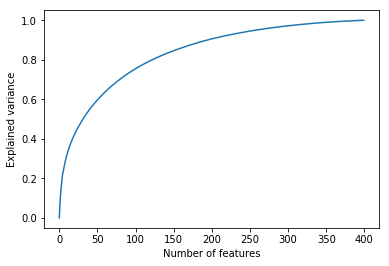

In [49]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.show()


PCA Predictor

In [50]:
%%time
# this takes a little while, around 7mins
#pca_predictor = pca.deploy(initial_instance_count=1, 
#                           instance_type='ml.t2.medium')

pca_transformer = pca.transformer(instance_count = 1, instance_type = 'ml.m5.large')

CPU times: user 26.6 ms, sys: 472 µs, total: 27.1 ms
Wall time: 372 ms


In [ ]:
from sys import getsizeof
a = [0] * 1024
#b = np.array(a)
getsizeof(np_azdias)

#>>> b.nbytes

In [51]:
del(formatted_azdias_data)

In [60]:
import pickle
import joblib

# upload without using disk
azdias_array_data = io.BytesIO()

filename = 'np_azdias.sav'

#joblib.dump(azdias_df.to_csv(), filename)  
joblib.dump(azdias_df.loc[1].to_csv(), filename)



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


['np_azdias.sav']

In [76]:
azdias_df.loc[1].to_csv("azdias.csv",header = False,index=False, encoding="utf-8" )

In [83]:
data_dir = "data/"
#s3_client.upload_fileobj(filename, bucket_name, 'np_azdias.sav')
#np_azdias_location = session.upload_data(os.path.join('np_azdias.sav'), key_prefix=prefix)
np_azdias_location = session.upload_string_as_file_body(azdias_df.loc[1].to_csv(header = False, 
                                                                                index = False,
                                                                                encoding="utf-8"),
                                                        bucket = bucket_name, 
                                                        key =prefix)

Delete temp file from sagemaker notebook

In [62]:
os.remove("np_azdias.sav")

In [84]:
%%time

# pass np train data to the PCA model
#train_pca = pca_predictor.predict(np_azdias)
train_pca = pca_transformer.transform(np_azdias_location, content_type='text/csv', split_type='Line')

CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 322 ms


In [85]:
pca_transformer.wait()

......................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[04/26/2020 19:36:18 INFO 140458699810624] loaded entry point class algorithm.serve.server_config:config_api
[04/26/2020 19:36:18 INFO 140458699810624] nvidia-smi took: 0.0251150131226 secs to identify 0 gpus
[04/26/2020 19:36:18 INFO 140458699810624] loading entry points
[04/26/2020 19:36:18 INFO 140458699810624] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[04/26/2020 19:36:18 INFO 140458699810624] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[04/26/2020 19:36:18 INFO 140458699810624] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[04/26/2020 19:36:18 INFO 140458699810624] loaded request iterator text/csv
[04/26/2020 19:36:18 INFO 140458699810624] loaded request iterator application/x-recordi

2020-04-26T19:36:31.444:[sagemaker logs]: MaxConcurrentTransforms=2, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-04-26 19:37:02 +0000] [1] [CRITICAL] WORKER TIMEOUT (pid:83)
[2020-04-26 19:37:02 +0000] [1] [CRITICAL] WORKER TIMEOUT (pid:92)
[2020-04-26 19:37:02 +0000] [103] [INFO] Booting worker with pid: 103
[04/26/2020 19:37:02 INFO 140458699810624] loading model...
[04/26/2020 19:37:02 INFO 140458699810624] ...model loaded.
[04/26/2020 19:37:02 WARNING 140458699810624] Requesting context without setting the requested num of gpus. Using 'auto'
[04/26/2020 19:37:02 INFO 140458699810624] Number of GPUs being used: 0
[04/26/2020 19:37:02 INFO 140458699810624] The default executor is <PCAModel on cpu(0)>.
[04/26/2020 19:37:02 INFO 140458699810624] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 501.
[04/26/2020 19:37:02 ERROR 140458699810624] Algorithm Error: [19:37:02] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x.3130.0/AL2012/generic-flavor/

2020-04-26T19:37:32.246:[sagemaker logs]: sagemaker-eu-west-1-848439228145/arvato: Unable to get response from algorithm
[bt] (6) /opt/amazon/lib/libmxnet.so(MXImperativeInvokeEx+0x67) [0x7fbf03d27327]
[bt] (7) /opt/amazon/python2.7/lib/python2.7/lib-dynload/_ctypes.so(ffi_call_unix64+0x4c) [0x7fbf15362958]
[bt] (8) /opt/amazon/python2.7/lib/python2.7/lib-dynload/_ctypes.so(ffi_call+0x15f) [0x7fbf15361a5f]
[bt] (9) /opt/amazon/python2.7/lib/python2.7/lib-dynload/_ctypes.so(_ctypes_callproc+0x292) [0x7fbf15359552]


#metrics {"Metrics": {"invocations_error.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929852.241433, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929852.20507}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929852.241576, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 15879298

#metrics {"Metrics": {"invocations_error.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929882.414828, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929882.387529}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929882.415184, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929882.415137}

[2020-04-26 19:38:02 +0000] [144] [INFO] Worker exiting (pid: 144)
[04/26/2020 19:38:02 ERROR 140458699810624] Algorithm Error:  (caused by UnicodeEncodeError)

Caused by: 'ascii' codec can't encode character u'\ufffd' in position 0: ordinal not in range(128)
#metrics {"Metrics": {"invocations_error.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929882.464368, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929882.404926}


[2020-04-26 19:39:32 +0000] [205] [INFO] Worker exiting (pid: 205)
#metrics {"Metrics": {"invocations_error.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929972.718356, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929972.670935}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929972.718496, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929972.718473}

[2020-04-26 19:39:32 +0000] [214] [INFO] Worker exiting (pid: 214)
[2020-04-26 19:39:32 +0000] [205] [INFO] Worker exiting (pid: 205)
#metrics {"Metrics": {"invocations_error.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587929972.718356, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587929972.670935}

#metrics {"Metrics": {"invocations.count": {"count": 1, "m

[04/26/2020 19:41:03 INFO 140458699810624] loading model...
[04/26/2020 19:41:03 INFO 140458699810624] ...model loaded.
[04/26/2020 19:41:03 INFO 140458699810624] loading model...
[04/26/2020 19:41:03 INFO 140458699810624] ...model loaded.
[04/26/2020 19:41:03 ERROR 140458699810624] Algorithm Error:  (caused by UnicodeEncodeError)

Caused by: 'ascii' codec can't encode character u'\ufffd' in position 0: ordinal not in range(128)
[2020-04-26 19:41:03 +0000] [276] [INFO] Booting worker with pid: 276
#metrics {"Metrics": {"invocations_error.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587930063.106917, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1587930063.073175}

[04/26/2020 19:41:03 INFO 140458699810624] loading model...
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1587930063.10754, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm"

UnexpectedStatusException: Error for Transform job pca-2020-04-26-19-32-44-822: Failed. Reason: InternalServerError: We encountered an internal error.  Please try again.

## K-Means model

In [ ]:
# define a KMeans estimator
k_estimator = sagemaker.KMeans(role,
                               train_instance_count = 1,
                               train_instance_type = 'ml.m5.large',
                               k = 8
                              )

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')